## AEs used as noise removers

The idea is, in order to represent the underlying relations and represent in the small size encoding the AEs only look at the object image and not the noise, which is eliminated

Here we do not need to restrict the number of nodes or use a regularizer as we have a different input and output and the memorization problems do not exist any longer


In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14,8

import warnings
warnings.filterwarnings('ignore')

## Train/test split

In [2]:
(X_train_n,_), (X_test_n,_) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
(X_train_fs,_), (X_test_fs,_) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
X_train_n = X_train_n.astype('float32')/255
X_test_n = X_test_n.astype('float32')/255

In [5]:
X_train_fs = X_train_fs.astype('float32')/255
X_test_fs = X_test_fs.astype('float32')/255

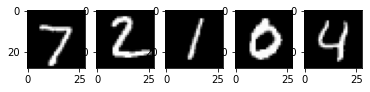

In [6]:
count = 5
plt.figure()

for i in range(count):
  ax = plt.subplot(2, count, i+1)
  plt.imshow(X_test_n[i].reshape(28,28))
  plt.gray()

plt.show()

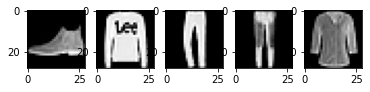

In [7]:
count = 5
plt.figure()

for i in range(count):
  ax = plt.subplot(2, count, i+1)
  plt.imshow(X_test_fs[i].reshape(28,28))
  plt.gray()

plt.show()

In [8]:
X_train_n = X_train_n[..., tf.newaxis]
X_test_n = X_test_n[..., tf.newaxis]

In [9]:
X_train_n.shape

(60000, 28, 28, 1)

In [10]:
X_train_fs = X_train_fs[..., tf.newaxis]
X_test_fs = X_test_fs[..., tf.newaxis]

In [11]:
X_train_fs.shape

(60000, 28, 28, 1)

### Noise

In [12]:
noise_factor = 0.5

X_train_n_noisy = X_train_n + noise_factor * np.random.normal(
    loc=0.0, 
    scale=1.0, 
    size=X_train_n.shape
)

X_test_n_noisy = X_test_n + noise_factor * np.random.normal(
    loc=0.0, 
    scale=1.0, 
    size=X_test_n.shape
) 

X_train_n_noisy = np.clip(X_train_n_noisy, 0., 1.)
X_test_n_noisy = np.clip(X_test_n_noisy, 0., 1.)

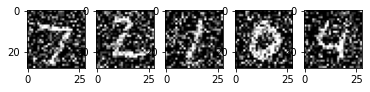

In [13]:
count = 5
plt.figure()

for i in range(count):
  ax = plt.subplot(2, count, i+1)
  plt.imshow(X_test_n_noisy[i].reshape(28,28))
  plt.gray()

plt.show()

In [14]:
noise_factor = 0.3

X_train_fs_noisy = X_train_fs + noise_factor * np.random.normal(
    loc=0.0, 
    scale=1.0, 
    size=X_train_fs.shape
)

X_test_fs_noisy = X_test_fs + noise_factor * np.random.normal(
    loc=0.0, 
    scale=1.0, 
    size=X_test_fs.shape
) 

X_train_fs_noisy = np.clip(X_train_fs_noisy, 0., 1.)
X_test_fs_noisy = np.clip(X_test_fs_noisy, 0., 1.)

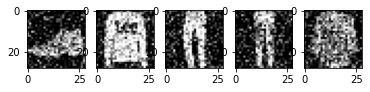

In [15]:
count = 5
plt.figure()

for i in range(count):
  ax = plt.subplot(2, count, i+1)
  plt.imshow(X_test_fs_noisy[i].reshape(28,28))
  plt.gray()

plt.show()

## Model

In [16]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, UpSampling2D, Conv2D

### AE architecture

In [17]:
input_layer = Input(shape=(28,28,1))

encoding = Conv2D(32, (3,3), 
                    activation='relu',
                    padding='same')(input_layer)
maxp = MaxPooling2D((2,2), 
                    padding='same')(encoding)

encoding = Conv2D(16, (3,3), 
                  activation='relu',
                  padding='same')(maxp)
maxp = MaxPooling2D((2,2), 
                    padding='same')(encoding)

encoding = Conv2D(8, (3,3), 
                  activation='relu',
                  padding='same')(maxp)

code = MaxPooling2D((2,2), 
                    padding='same')(encoding)

decoding = Conv2D(8, (3,3), 
                  activation='relu', 
                  padding='same')(code)

Up = UpSampling2D((2,2))(decoding)

decoding = Conv2D(16, (3,3), 
                  activation='relu', 
                  padding='same')(Up)

Up = UpSampling2D((2,2))(decoding)

decoding = Conv2D(32, (3,3), 
                  activation='relu')(Up)

Up = UpSampling2D((2,2))(decoding)

output_layer = Conv2D(1, (3,3),
                activation='sigmoid',
                padding='same')(Up)

ae = Model(inputs=[input_layer], outputs=[output_layer])

In [ ]:
ae.summary()

In [19]:
encoder = Model(inputs=input_layer, outputs=[code])

In [ ]:
encoder.summary()

In [21]:
ae.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
ae.fit(
    X_train_fs, X_train_fs,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_fs, X_test_fs)
)

Epoch 1/5
235/235 [==============================] - 121s 510ms/step - loss: 0.4777 - val_loss: 0.3127
Epoch 2/5
235/235 [==============================] - 120s 509ms/step - loss: 0.3067 - val_loss: 0.3006
Epoch 3/5
235/235 [==============================] - 124s 529ms/step - loss: 0.2973 - val_loss: 0.2958
Epoch 4/5
235/235 [==============================] - 121s 513ms/step - loss: 0.2927 - val_loss: 0.2928
Epoch 5/5
235/235 [==============================] - 119s 508ms/step - loss: 0.2907 - val_loss: 0.2924
